---
author: Zeel B Patel
badges: true
categories: ML
description: Active Learning with MNIST
title: Active Learning with MNIST
date: '2023-09-30'
toc: true
---

## Imports

In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt
from tqdm import tqdm

import psutil

## Load data

In [16]:
X, y = fetch_openml('mnist_784', version=1, data_home='data', return_X_y=True, as_frame=False)

/home/patel_zeel/miniconda3/lib/python3.9/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## 

In [17]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(60000, 784) (10000, 784) (60000,) (10000,)


## Check if things are working as expected

In [18]:
%%time

clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0, n_jobs=psutil.cpu_count()//2)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.94      0.94      0.94      1032
           3       0.94      0.94      0.94      1010
           4       0.95      0.93      0.94       982
           5       0.96      0.93      0.94       892
           6       0.96      0.97      0.96       958
           7       0.95      0.92      0.94      1028
           8       0.94      0.93      0.93       974
           9       0.88      0.94      0.91      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

CPU times: user 1min 33s, sys: 652 ms, total: 1min 34s
Wall time: 3.73 s


## Convert to one v/s rest problem

In [19]:
y_c = (y == '2').astype(np.int8)

y_c_train, y_c_test = y_c[:60000], y_c[60000:]

## Check if things are working as expected

In [20]:
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0, n_jobs=psutil.cpu_count()//2)
clf.fit(X_train, y_c_train)
preds = clf.predict(X_test)

In [21]:
print("Precision", precision_score(y_c_test, preds))
print("Recall", recall_score(y_c_test, preds))

Precision 0.9808988764044944
Recall 0.8459302325581395


## Divide data into train and pool

In [32]:
train_size = 200
X_train, X_pool, y_c_train, y_c_pool = train_test_split(X, y_c, train_size=train_size, random_state=42)
print(X_train.shape, X_pool.shape, y_c_train.shape, y_c_pool.shape)

# plot a bar chart of the number of samples in each class for the training and test set
unique, counts = np.unique(y_c_train, return_counts=True)
print("Number of samples in each class for training set", dict(zip(unique, counts)))
print("One v/s rest ratio", counts[0]/counts[1], "for training set")

(200, 784) (69800, 784) (200,) (69800,)
Number of samples in each class for training set {0: 179, 1: 21}
One v/s rest ratio 8.523809523809524 for training set


## Prof. Ermon's method

In [25]:
X_train, X_pool, y_c_train, y_c_pool = train_test_split(X, y_c, train_size=train_size, random_state=42)
print(X_train.shape, X_pool.shape, y_c_train.shape, y_c_pool.shape)

clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0, n_jobs=psutil.cpu_count()//2)
clf.fit(X_train, y_c_train)
preds = clf.predict(X_test)

test_recall = [recall_score(y_c_test, preds)]
test_precision = [precision_score(y_c_test, preds)]
positives = [np.sum(y_c_train)]
negatives = [len(y_c_train) - positives[-1]]
labeling_cost = [0]
tp = np.where((preds == 1) & (y_c_test == 1))[0]
fp = np.where((preds == 1) & (y_c_test == 0))[0]
print("Test: Number of false positives", len(fp), "Number of true positives", len(tp))
print("Iteration", 0, "Precision", test_precision[-1], "Recall", test_recall[-1], "Cost", labeling_cost[-1])

al_iters = 10

for iter in range(al_iters):
    print()
    preds = clf.predict(X_pool)
    # pred_proba = clf.predict_proba(X_pool)
    # print(pred_proba.shape)
    # identify instances predicted as positive but are actually negative (false positives)
    # we only pick points with more than 90% probability of being positive
    # fp = np.where((pred_proba[:, 1] > 0.8) & (y_pool == 0))[0]
    fp = np.where((preds == 1) & (y_c_pool == 0))[0]
    tp = np.where((preds == 1) & (y_c_pool == 1))[0]
    fn = np.where((preds == 0) & (y_c_pool == 1))[0]
    print("Pool: Number of false positives", len(fp), "Number of true positives", len(tp), "Number of false negatives", len(fn))
    tp_fp = np.concatenate((tp, fp))
    # add them to the training set
    X_train = np.concatenate((X_train, X_pool[tp_fp]))
    y_c_train = np.concatenate((y_c_train, y_c_pool[tp_fp]))
    positives.append(np.sum(y_c_train))
    negatives.append(len(y_c_train) - positives[-1])
    # remove from the pool set
    X_pool = np.delete(X_pool, tp_fp, axis=0)
    y_c_pool = np.delete(y_c_pool, tp_fp)
    # add the cost of labeling to the list
    labeling_cost.append(len(tp_fp))
    # train the classifier again
    clf.fit(X_train, y_c_train)
    # predict on the test set
    preds = clf.predict(X_test)
    tp = np.where((preds == 1) & (y_c_test == 1))[0]
    fp = np.where((preds == 1) & (y_c_test == 0))[0]
    fn = np.where((preds == 0) & (y_c_test == 1))[0]
    print("Test: Number of false positives", len(fp), "Number of true positives", len(tp), "Number of false negatives", len(fn))
    # calculate precision and recall
    test_recall.append(recall_score(y_c_test, preds))
    test_precision.append(precision_score(y_c_test, preds))
    # print information
    print("Iteration", iter+1, "Precision", test_precision[-1], "Recall", test_recall[-1], "Cost", labeling_cost[-1])

labeling_cost = np.cumsum(labeling_cost)

(200, 784) (69800, 784) (200,) (69800,)
Test: Number of false positives 8 Number of true positives 283
Iteration 0 Precision 0.9725085910652921 Recall 0.2742248062015504 Cost 0

Pool: Number of false positives 73 Number of true positives 1884 Number of false negatives 5085
Test: Number of false positives 209 Number of true positives 932 Number of false negatives 100
Iteration 1 Precision 0.8168273444347064 Recall 0.9031007751937985 Cost 1957

Pool: Number of false positives 1389 Number of true positives 4386 Number of false negatives 699
Test: Number of false positives 489 Number of true positives 1016 Number of false negatives 16
Iteration 2 Precision 0.6750830564784053 Recall 0.9844961240310077 Cost 5775

Pool: Number of false positives 4088 Number of true positives 598 Number of false negatives 101
Test: Number of false positives 12 Number of true positives 1006 Number of false negatives 26
Iteration 3 Precision 0.9882121807465619 Recall 0.9748062015503876 Cost 4686

Pool: Number of

Text(0, 0.5, 'True Label')

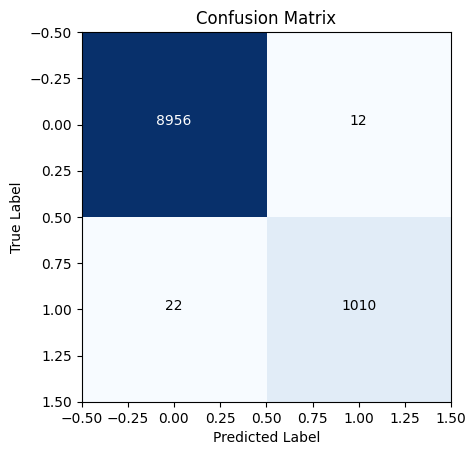

In [26]:
# plot the confusion matrix
import itertools
cm = confusion_matrix(y_c_test, preds)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
# add the numbers inside the boxes
thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

In [31]:
pd.DataFrame({"Cost": labeling_cost, "Train_Positives": positives, "Train_Negatives": negatives, "Test_Precision": test_precision, "Test_Recall": test_recall})

,Cost,Train_Positives,Train_Negatives,Test_Precision,Test_Recall
0,0,21,179,0.972509,0.274225
1,1957,1905,252,0.816827,0.903101
2,7732,6291,1641,0.675083,0.984496
3,12418,6889,5729,0.988212,0.974806
4,12451,6904,5747,0.990196,0.978682
5,12469,6909,5760,0.989226,0.978682
6,12476,6911,5765,0.990206,0.979651
7,12482,6912,5770,0.991176,0.979651
8,12489,6914,5775,0.989226,0.978682
9,12496,6916,5780,0.991168,0.978682
